# Brain Imaging Visualization & Recent Development in Generative Models

Zhiling Gu, 2025-11-18

https://guzhiling.com

This class is divided into two parts:
1. Brain Imaging Visualization for NifTi files
  - 3D imaging slices
  - brain surface ploting
  - animated imaging

2. Generative Models
  - Diffusion models
  - Flow Matching
  - Normalizing Flows

# Brain Imaging Visualization

In [1]:
!pip install nilearn # To install a package: `pip install nilearn` in terminal, or `!pip install nilearn` inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 28.1 MB/s eta 0:00:00


In [2]:
import argparse
import seaborn as sns
import sympy as sp
import numpy as np
import pandas as pd

from scipy.special import expit, logit
from scipy.stats import norm
from scipy.optimize import minimize
import torch
from time import sleep
from tqdm import tqdm

import torch
from torch.utils.data import TensorDataset
from numpy import pi, cos, sin, arccos, arange
import os
from PIL import Image
from torch.utils.data import Dataset
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable, get_cmap
from IPython.display import clear_output


## Data format: **NIfTI (.nii / .nii.gz)**
Neuroimaging data is often stored in the format of **NIfTI** files `.nii` which can also be compressed using gzip `.nii.gz`.  These files store both 3D and 4D data and also contain structured metadata in the image **header**.

There is an very nice tool to access nifti data stored on your file system in python called [nibabel](http://nipy.org/nibabel/).  If you don't already have nibabel installed on your computer it is easy via `pip`. First, tell the jupyter cell that you would like to access the unix system outside of the notebook and then install nibabel using pip. You only need to run this once (unless you would like to update the version).

References:
- https://doubleshow.github.io/bai-book/labs/lab-image


In [3]:
!pip install nibabel

In [4]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import datasets

In [5]:
# load toy data in nilearn
img = datasets.load_mni152_template()
print(img.get_fdata().shape) # data shape: (197, 233, 189) = [dim(x), dim(y), dim(z)]

(197, 233, 189)


## ⚓ Interpreting the dimension `data.shape` **(197, 233, 189)**:
- 197 voxels along x-axis
- 233 voxels along y-axis
- 189 voxels along z-axis
- If the NIfTI contains a time series or multiple volumes (e.g., fMRI), the shape could be (X, Y, Z, T) where T is the number of time points.



In [6]:
# additional meta information
print(img)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (197, 233, 189)
affine:
[[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [  3 197 233 189   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.byte

## ⚓  Interpreting **affine matrix:**
A mapping from 3D coordinates (integers) to real world spatial coordinates (millemeters):

**[x_world, y_world, z_world, 1] = affine @ [i, j, k, 1]**

Example affine matrix:
```
[[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
 ```
- Diagonal [1,1,1]:
  - These are voxel sizes along x, y, z axes (1 mm each here).
  - If it were [2,2,2], each voxel would cover 2 mm³.


- Last column [-98, -134, -72]
  - These are translations, shifting the origin (voxel [0,0,0]) to a specific real-world location.
  - So voxel (0,0,0) corresponds to (x=-98, y=-134, z=-72) in world coordinates.
  - Important for aligning different templates!

- Bottom row [0,0,0,1]
  - Standard for homogeneous coordinates
  - allows affine transformations including rotation, scaling, shearing, and translation.

## ♨ Exercise 0 (10 min):
0. Run through the code we just demonstrated.
1. Calculate the range of real-world coordinates of x-axis, y-axis and z-axis

**Hint:**
1. matrix calculation of `[x_world, y_world, z_world, 1] = affine @ [i, j, k, 1]`
  - affine can be found by calling `img.affine`
  - the maximum of `i,j,k` is determined by the dimension `img.shape`
  - the minimum of `i,j,k` is `0`

In [7]:
affine = img.affine
print(affine)
img_shape = img.get_fdata().shape
print(img_shape)
img.shape
# xaxis: ranges from 0 to 196
x_range = np.arange(197)
y_range = np.arange(233)
z_range = np.arange(189)

print(affine @ [0,0,0, 1])
print(affine @ [196, 232, 188, 1])

[[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
(197, 233, 189)
[ -98. -134.  -72.    1.]
[ 98.  98. 116.   1.]


In [8]:
# Answer key:
import numpy as np
import nibabel as nib

def world_ranges_from_img(img):
    """
    Given a nibabel image, return (xmin,xmax), (ymin,ymax), (zmin,zmax)
    in world coordinates (same units as affine, typically mm).
    """
    affine = img.affine            # 4x4
    I, J, K = img.shape[:3]       # voxel counts along each axis

    # corner voxel indices: all combinations of 0 or max index
    corners = np.array([[i, j, k, 1]
                        for i in (0, I-1)
                        for j in (0, J-1)
                        for k in (0, K-1)])

    # map to world coordinates
    world_corners = (affine @ corners.T).T  # shape (8,4)

    # take only x,y,z (first three columns)
    xyz = world_corners[:, :3]

    x_min, y_min, z_min = xyz.min(axis=0)
    x_max, y_max, z_max = xyz.max(axis=0)

    ranges = {
        'x': (float(x_min), float(x_max)),
        'y': (float(y_min), float(y_max)),
        'z': (float(z_min), float(z_max)),
    }
    return ranges, xyz

# Example usage:
ranges, xyz_corners = world_ranges_from_img(img)
print("World coordinate ranges (mm):")
print(" x:", ranges['x'])
print(" y:", ranges['y'])
print(" z:", ranges['z'])

# Optionally inspect all 8 corner coordinates
print("\nWorld coordinates of the 8 volume corners:")
for c in xyz_corners:
    print(c)

World coordinate ranges (mm):
 x: (-98.0, 98.0)
 y: (-134.0, 98.0)
 z: (-72.0, 116.0)

World coordinates of the 8 volume corners:
[ -98. -134.  -72.]
[ -98. -134.  116.]
[-98.  98. -72.]
[-98.  98. 116.]
[  98. -134.  -72.]
[  98. -134.  116.]
[ 98.  98. -72.]
[ 98.  98. 116.]


## Ploting 3D Images using `plt.imshow`

In [9]:
print(img.get_fdata().shape)
print(img.get_fdata()[:,0,:].shape)

(197, 233, 189)
(197, 189)


(197, 189)

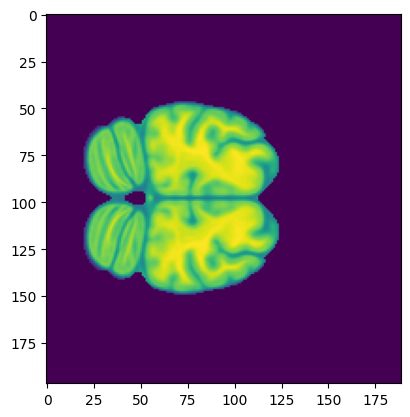

In [10]:
# Print a slice of image (51st y slice)
plt.imshow(img.get_fdata()[:,50,:])
img.get_fdata()[:,50,:].shape

(197, 233)

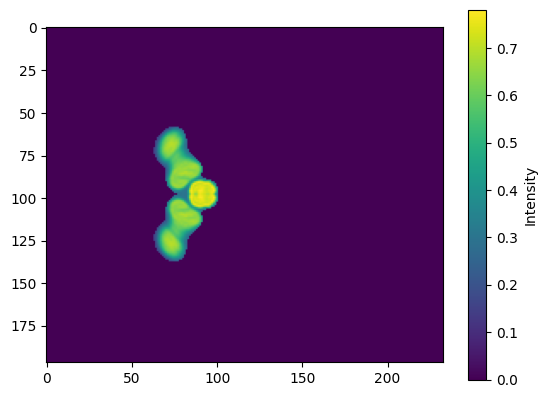

In [11]:
# Print another size of image (11th z slice)
plt.imshow(img.get_fdata()[:,:,10])
plt.colorbar(label="Intensity")  # Add colorbar with label
img.get_fdata()[:,:,10].shape

In [12]:
import nibabel as nib
import matplotlib.pyplot as plt
import imageio
import numpy as np
from io import BytesIO

# Load NIfTI file
data = img.get_fdata()

# Parameters
axis = 0  # x-axis
output_gif = "brain_xaxis.gif"
frames = []
vmin, vmax = np.min(data), np.max(data)

# Loop over slices
for i in range(data.shape[axis]):
    slice_img = data[:, i, :]
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(slice_img.T, cmap="gray", origin="lower", vmin=vmin, vmax=vmax)
    ax.axis("off")

    # Save figure to in-memory buffer
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    frame = imageio.v2.imread(buf)
    frames.append(frame)
    plt.close(fig)

# Save GIF
imageio.mimsave(output_gif, frames, fps=10)
print(f"Saved GIF to {output_gif}")


Saved GIF to brain_xaxis.gif


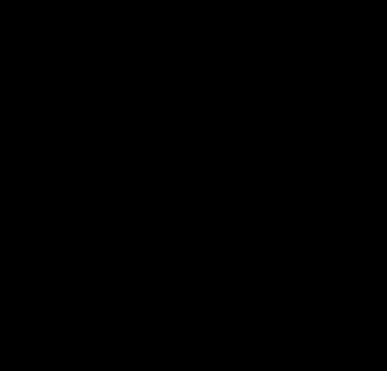

In [13]:
from IPython.display import Image
Image("brain_xaxis.gif")

## ♨ Exercise 1 (10 min):
0. Run through the code we just demonstrated.
1. Create a GIF that slices over y axis.
2. Plot a static figure that combines the 21st, 41st, 61st, 81st, ...., 201st slice on y-axis (see below)

**Hint:**
1. Modify this line `slice_img = data[i, :, :]`
2. Use function `plt.subplot`



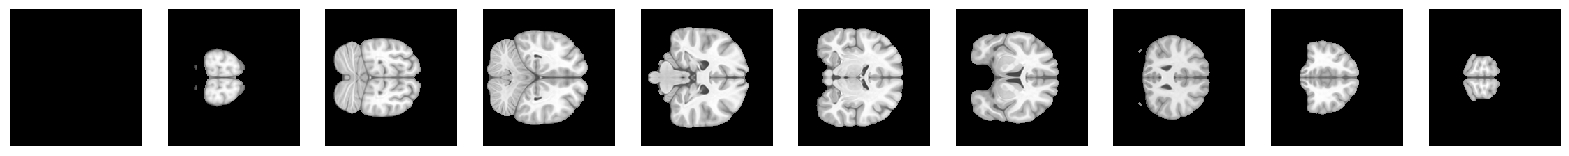

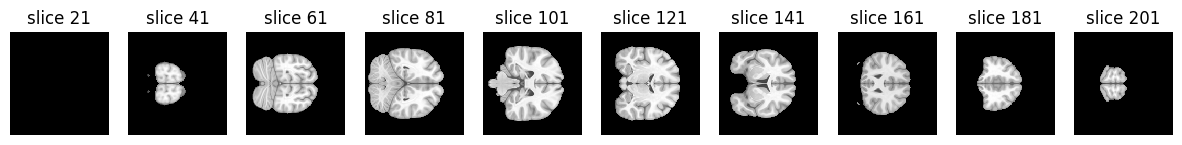

In [14]:
# Answer Key:
plt.figure(figsize=(15, 10))
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    plt.subplot(1,10,i)
    plt.imshow(img.get_fdata()[:,i*20,:], 'gray', interpolation='none')
    plt.axis("off")
    plt.title(f"slice {i*20+1}")
plt.show()

## Plotting 3D images using `plot_stat_map`
On top of viewing the 3D image from a single view, we could also plot the intensity from 3-view points all together.

Reference: https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_3d_and_4d_niimg.html#sphx-glr-auto-examples-00-tutorials-plot-3d-and-4d-niimg-py

(53, 63, 46)


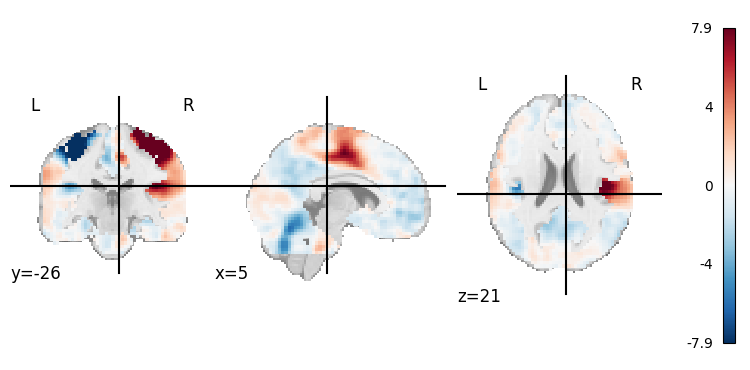

In [15]:
from nilearn.plotting import plot_stat_map
# plot example motor activation map (load from `nilearn`/data/image_10426.nii.gz)
img_path = datasets.load_sample_motor_activation_image()
img = nib.load(img_path)

plot_stat_map(img) # no threshold
print(img.get_fdata().shape)

In [ ]:
print(img.shape)

(53, 63, 46)




> Here `datasets.load_sample_motor_activation_image()` returns a string where the `.nii.gz` file locates, thus we need to load it using `nib.load()` before getting the shapes.



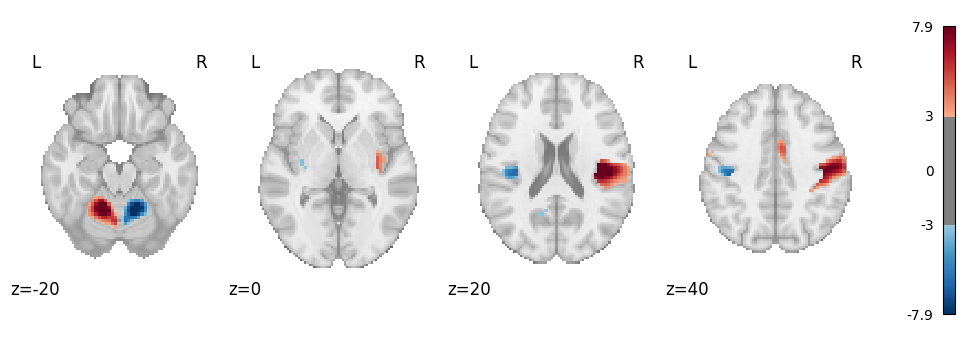

In [ ]:
# Plot in Z direction at different slice coordinates (in mm MNI space)
plot_stat_map(
    img,
    display_mode='z',      # slice along z-axis
    cut_coords=[-20, 0, 20, 40],  # choose real-world coordinates of slices
    threshold=3,
    colorbar=True
)

## ♨ Exercise 2 (5 min):
0. Run through the code we just demonstrated.
1. Plot a static figure that output 10 slices on the yaxis.
2. Plot a static figure that combines the 1st, 11st, 21st,..., 61st slice on y-axis (optional)

**Hint:**
1. investigate the `cut_coords` parameter
2. be aware of whether the coordinates are in real-world coordinates OR slice indices. potentially, you could use affine matrix to recover real-world coordinates from slice indices (optional)

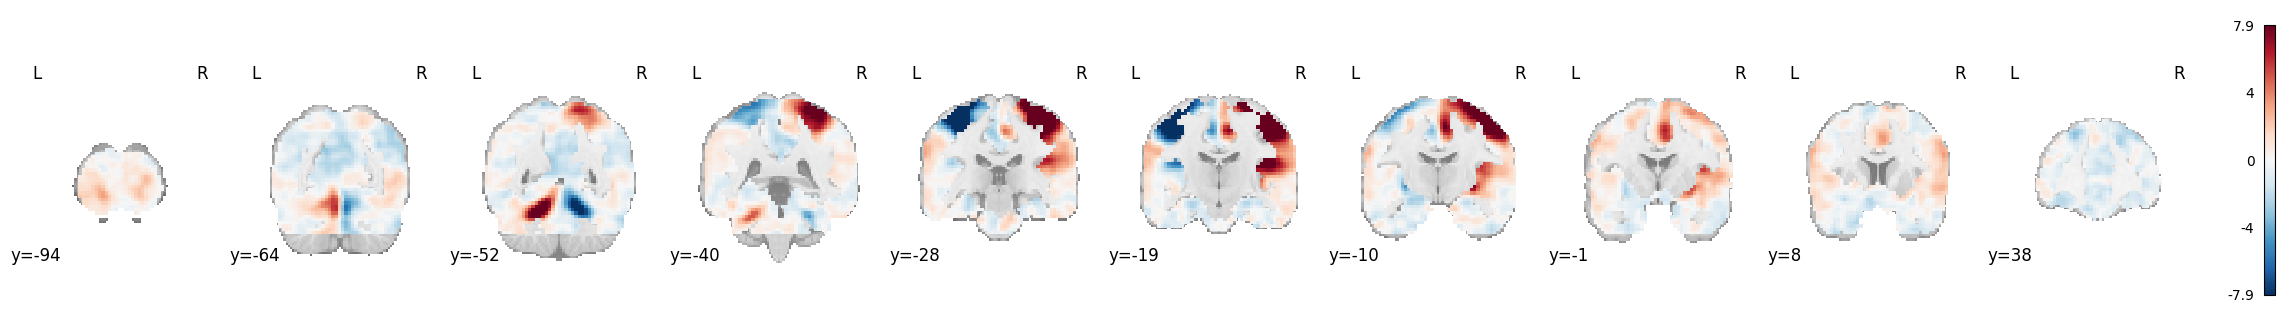

In [ ]:
if True:
  total_seconds = 5 * 60  # X minutes
  for t in tqdm(range(total_seconds, -1, -1)):
      sleep(1)

 19%|█▉        | 58/301 [00:58<04:04,  1.01s/it]


KeyboardInterrupt: 

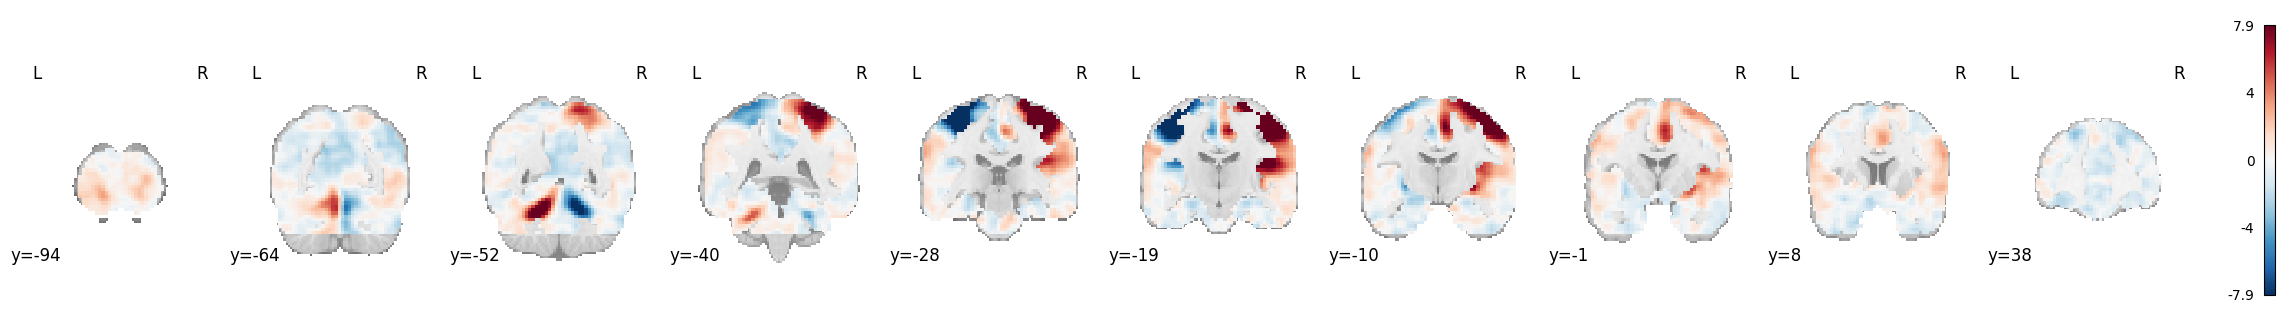

In [ ]:
# Answer key 1: a rough answer, give the number of evenly spaced slices
plot_stat_map(img, display_mode='y', cut_coords=10)

(53, 63, 46)
[ 0 10 20 30 40 50 60]
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -112.]
 [   0.    0.    3.  -50.]
 [   0.    0.    0.    1.]]
[-112  -82  -52  -22    8   38   68] [np.float64(-112.0), np.float64(-82.0), np.float64(-52.0), np.float64(-22.0), np.float64(8.0), np.float64(38.0), np.float64(68.0)]


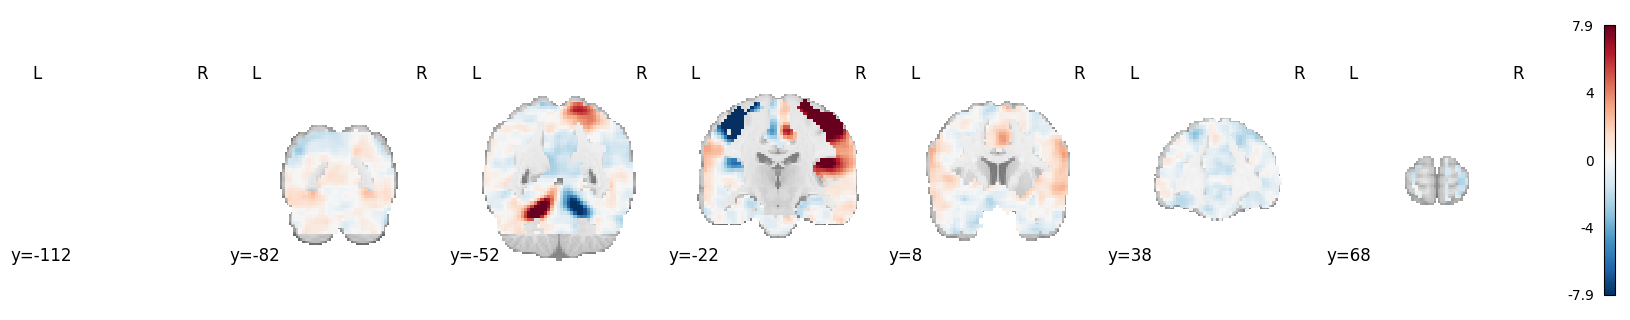

In [ ]:
# Answer key 2: manually input the slices over a loop
print(img.shape)
# get y slice indices
y_slice_ind = np.arange(0, 61, 10)
print(y_slice_ind)
# get affine matrix
affine = img.affine
print(affine) # 3mm between slices
# calculate y real-world coords
y_coords = 3 * y_slice_ind -112
y_coords_mm = [[affine @ [0, y, 0, 1]][0][1] for y in y_slice_ind]
print(y_coords, y_coords_mm) # both works
# plot the wanted slices
plot_stat_map(img,
              display_mode='y',
              cut_coords=y_coords_mm,
              colorbar=True)

## 3D plot on the brain surface

We could also plot the intensity on the brain surface overlayed by brain regions for better identification of brain regions.



One key step to plot the brain surface require **Volumn-to-Surface** transformation, i.e. from (x,y,z) coordinates to surface coordinates.


Reference: https://nilearn.github.io/dev/auto_examples/01_plotting/plot_3d_map_to_surface_projection.html#sphx-glr-auto-examples-01-plotting-plot-3d-map-to-surface-projection-py


In [ ]:
from nilearn.datasets import load_sample_motor_activation_image
# Step 1: load volumetric data
img_path = load_sample_motor_activation_image()
stat_img = nib.load(img_path)
stat_img.get_fdata().shape

(53, 63, 46)

In [ ]:
# Step 2: Load cortical mesh (i.e. surface mesh)
from nilearn.datasets import load_fsaverage
fsaverage_meshes = load_fsaverage()
fsaverage_meshes.sphere.n_vertices # number of vertices on the mesh

20484

In [ ]:
# Step 3: Construct a surface image from a volume.
from nilearn.surface import SurfaceImage
surface_image = SurfaceImage.from_volume(
    mesh=fsaverage_meshes["pial"],
    volume_img=stat_img,
)

In [ ]:
# Step 4: housekeeping - curvature map for background
import numpy as np
from nilearn.datasets import load_fsaverage_data

curv_sign = load_fsaverage_data(data_type="curvature")
for hemi, data in curv_sign.data.parts.items():
    curv_sign.data.parts[hemi] = np.sign(data)

### Surface plot


/tmp/ipython-input-2327387767.py:7: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  fig = plot_surf_stat_map(


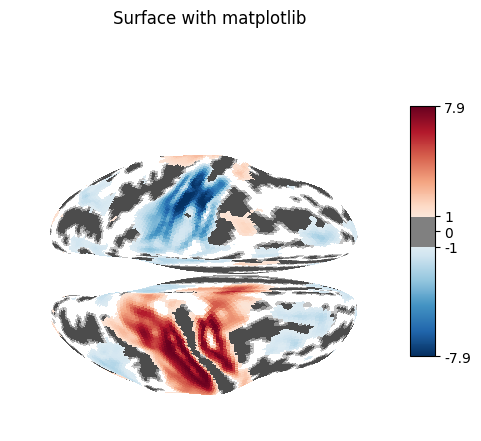

In [ ]:
# Surface plot
from nilearn.plotting import plot_surf_stat_map
# In this example we will plot both hemispheres, but you can choose one of
# "left", "right" or "both".
hemi = "both"

fig = plot_surf_stat_map(
    stat_map=surface_image,
    surf_mesh=fsaverage_meshes["inflated"],
    hemi=hemi,
    title="Surface with matplotlib",
    threshold=1.0,
    bg_map=curv_sign,
)
fig.show()

/tmp/ipython-input-470704630.py:3: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_img_on_surf(


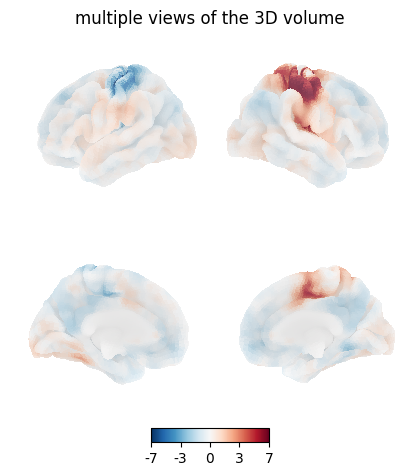

In [ ]:
# Plot multiple views of the 3D volume on a surface
from nilearn.plotting import plot_img_on_surf

plot_img_on_surf(
    stat_map=stat_img,
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    title="multiple views of the 3D volume",
    bg_on_data=True,
    symmetric_cmap=None,
)
show()

In [ ]:
# 3D visualization in a web browser
from nilearn.plotting import view_img_on_surf
view = view_img_on_surf(stat_img, threshold="90%")
view


### Surface plot overlayed by region boundaries


In [ ]:
from nilearn.datasets import fetch_atlas_surf_destrieux

fsaverage = load_fsaverage("fsaverage5")

# load a brain atlas
destrieux = fetch_atlas_surf_destrieux()
print(destrieux.labels) # check all regions labels in the atlas

destrieux_atlas = SurfaceImage(
    mesh=fsaverage["inflated"],
    data={
        "left": destrieux["map_left"],
        "right": destrieux["map_right"],
    },
)

# these are the regions we want to outline
regions_dict = {
    "G_postcentral": "Postcentral gyrus",
    "G_precentral": "Precentral gyrus"
}

# get indices in atlas for these labels
regions_indices = [
    np.where(np.array(destrieux.labels) == region)[0][0]
    for region in regions_dict
]

labels = list(regions_dict.values())

[fetch_atlas_surf_destrieux] Dataset found in /root/nilearn_data/destrieux_surface

['Unknown', 'G_and_S_frontomargin', 'G_and_S_occipital_inf', 'G_and_S_paracentral', 'G_and_S_subcentral', 'G_and_S_transv_frontopol', 'G_and_S_cingul-Ant', 'G_and_S_cingul-Mid-Ant', 'G_and_S_cingul-Mid-Post', 'G_cingul-Post-dorsal', 'G_cingul-Post-ventral', 'G_cuneus', 'G_front_inf-Opercular', 'G_front_inf-Orbital', 'G_front_inf-Triangul', 'G_front_middle', 'G_front_sup', 'G_Ins_lg_and_S_cent_ins', 'G_insular_short', 'G_occipital_middle', 'G_occipital_sup', 'G_oc-temp_lat-fusifor', 'G_oc-temp_med-Lingual', 'G_oc-temp_med-Parahip', 'G_orbital', 'G_pariet_inf-Angular', 'G_pariet_inf-Supramar', 'G_parietal_sup', 'G_postcentral', 'G_precentral', 'G_precuneus', 'G_rectus', 'G_subcallosal', 'G_temp_sup-G_T_transv', 'G_temp_sup-Lateral', 'G_temp_sup-Plan_polar', 'G_temp_sup-Plan_tempo', 'G_temporal_inf', 'G_temporal_middle', 'Lat_Fis-ant-Horizont', 'Lat_Fis-ant-Vertical', 'Lat_Fis-post', 'Medial_wall', 'Pole_occipital', 'Pole_temporal', 'S_calcarine', 'S_central', 'S_cingul-Marginalis', 'S_ci

/tmp/ipython-input-1088954182.py:6: UserWarning: 
The following regions are present in the atlas look-up table,
but missing from the atlas image:

 index    name
     0 Unknown

  destrieux = fetch_atlas_surf_destrieux()
/tmp/ipython-input-1088954182.py:6: UserWarning: 
The following regions are present in the atlas look-up table,
but missing from the atlas image:

 index    name
     0 Unknown

  destrieux = fetch_atlas_surf_destrieux()


/tmp/ipython-input-3572397408.py:5: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  figure = plot_surf_stat_map(


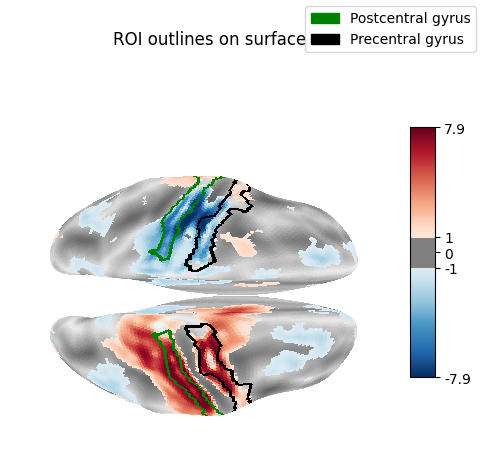

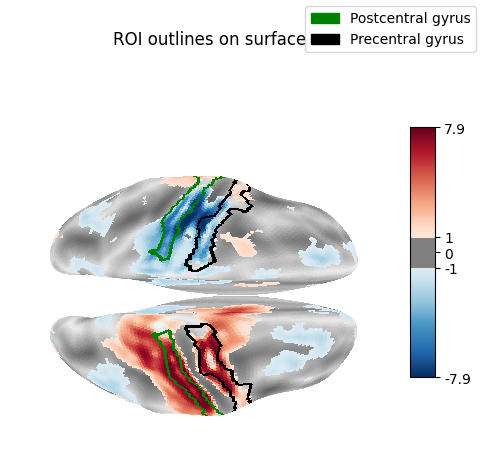

In [ ]:
from nilearn.plotting import plot_surf_contours
hemi = "both"
fsaverage_sulcal = load_fsaverage_data(data_type="sulcal", mesh_type="pial")

figure = plot_surf_stat_map(
    stat_map=surface_image,
    surf_mesh=fsaverage_meshes["inflated"],
    hemi=hemi,
    title="ROI outlines on surface",
    threshold=1.0,
    bg_map=fsaverage_sulcal,
    engine="matplotlib",
)
plot_surf_contours(
    roi_map=destrieux_atlas,
    hemi=hemi,
    labels=labels,
    levels=regions_indices,
    figure=figure,
    legend=True,
    colors=["g", "k"],
)


# Break 5 min

## ♨ Exercise 3 (10 min):
0. Run through the code we just demonstrated.
1. Overlay outlines of `'G_temporal_middle'` and `'G_temporal_middle'` on the surface

**Hint**:
1. Adjust the `regions_dict` to indicate regions of interest;  Adjust `view` parameter in `plot_surf_stat_map` for camera position adjustment

In [ ]:
total_seconds = 8 * 60  # 8 minutes
for t in tqdm.tqdm(range(total_seconds, -1, -1)):
    time.sleep(1)

[fetch_atlas_surf_destrieux] Dataset found in /root/nilearn_data/destrieux_surface

/tmp/ipython-input-1762270874.py:7: UserWarning:


The following regions are present in the atlas look-up table,
but missing from the atlas image:

 index    name
     0 Unknown


/tmp/ipython-input-1762270874.py:7: UserWarning:


The following regions are present in the atlas look-up table,
but missing from the atlas image:

 index    name
     0 Unknown


/tmp/ipython-input-1762270874.py:36: DeprecationWarning:

The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None



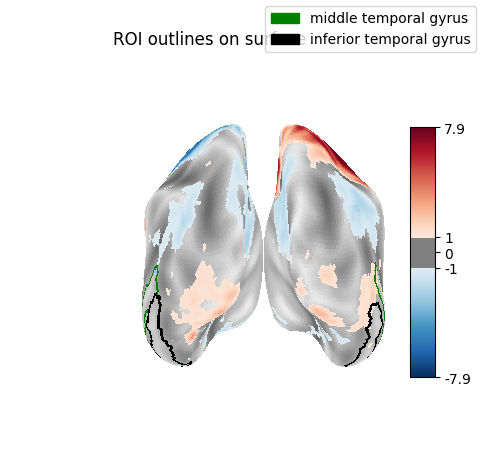

In [ ]:
# Anwer Key
from nilearn.datasets import fetch_atlas_surf_destrieux

fsaverage = load_fsaverage("fsaverage5")

# load a brain atlas
destrieux = fetch_atlas_surf_destrieux()

destrieux_atlas = SurfaceImage(
    mesh=fsaverage["inflated"],
    data={
        "left": destrieux["map_left"],
        "right": destrieux["map_right"],
    },
)

# these are the regions we want to outline
regions_dict = {
    "G_temporal_middle": "middle temporal gyrus",
    "G_temporal_inf": "inferior temporal gyrus"
}

# get indices in atlas for these labels
regions_indices = [
    np.where(np.array(destrieux.labels) == region)[0][0]
    for region in regions_dict
]

labels = list(regions_dict.values())

from nilearn.plotting import plot_surf_contours
engine = "matplotlib"
hemi = "both"
fsaverage_sulcal = load_fsaverage_data(data_type="sulcal", mesh_type="pial")

figure = plot_surf_stat_map(
    stat_map=surface_image,
    surf_mesh=fsaverage_meshes["inflated"],
    hemi="both",
    view = "posterior",
    title="ROI outlines on surface",
    threshold=1.0,
    bg_map=fsaverage_sulcal,
    engine="matplotlib",  # default
)
plot_surf_contours(
    roi_map=destrieux_atlas,
    hemi=hemi,
    labels=labels,
    levels=regions_indices,
    figure=figure,
    legend=True,
    colors=["g", "k"],
)

# Show the figure
figure.show()


# Generative Models

In the second half of the class, we talk about two types of most popular generative algorithms that have been trending.

1. Diffusion Model
2. Flow Matching


References:
- https://dsl-lab.github.io/blog/2024/flows
- https://ai.meta.com/research/publications/flow-matching-guide-and-code/

## Overview

We give an overview of Diffusion models, Flow Matching and Flows, as three representative generative models



<div style="text-align: center;">
  <img src="https://dsl-lab.github.io/blog/2024/flows/flow_methods.JPG" width="300">
</div>


## 🧠 1. Diffusion Models (DDPM)
Diffusion models learn to denoise a noisy sample step-by-step.
- Training: add Gaussian noise and learn the reverse denoising process.
- Sampling: start from pure noise → iteratively denoise to sample.


In [ ]:
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt

# -------------------- Device --------------------
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")      # Apple Silicon
    else:
        return torch.device("cpu")

device = get_device()
print("Using device:", device)

# -------------------- Data --------------------
X, _ = make_swiss_roll(5000, noise=0.05)
X = X[:, [0, 2]] / 15.0  # take 2D projection and scale
X = torch.tensor(X, dtype=torch.float32, device=device)

# -------------------- MLP denoiser --------------------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128), nn.ReLU(),   # 2D + t
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x, t):
        # x: (batch,2), t: (batch,1)
        x_cat = torch.cat([x, t], dim=-1)
        return self.net(x_cat)

# -------------------- Diffusion schedule --------------------
T = 1000
betas = torch.linspace(1e-4, 0.02, T, device=device)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

# -------------------- Model + optimizer --------------------
model_ddpm = MLP().to(device)
opt = torch.optim.Adam(model_ddpm.parameters(), lr=1e-3)
model_ddpm.train()

# -------------------- Training --------------------
for step in range(5000):
    idx = torch.randint(0, T, (256,), device=device)
    x0 = X[torch.randint(0, len(X), (256,), device=device)]
    epsilon = torch.randn_like(x0)

    a = alphas_bar[idx].unsqueeze(1)
    xt = torch.sqrt(a) * x0 + torch.sqrt(1 - a) * epsilon

    t_embed = idx.float().unsqueeze(1) / T
    pred = model_ddpm(xt, t_embed)

    loss = ((pred - epsilon) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % 500 == 0:
        print(f"step {step}, loss {loss.item():.4f}")

Using device: cpu
step 0, loss 0.9132
step 500, loss 0.1624
step 1000, loss 0.1822
step 1500, loss 0.1688
step 2000, loss 0.1498
step 2500, loss 0.1850
step 3000, loss 0.1601
step 3500, loss 0.1489
step 4000, loss 0.2136
step 4500, loss 0.1346


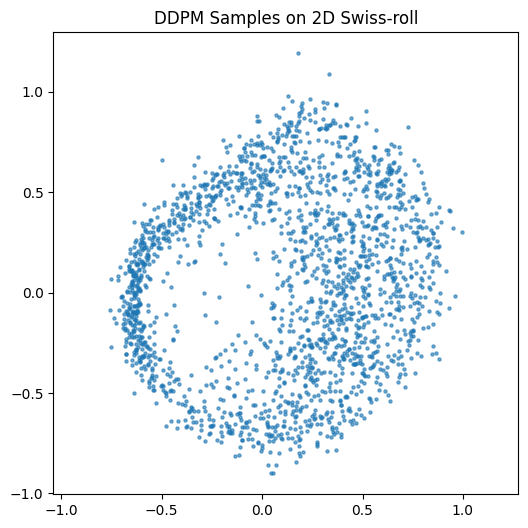

In [ ]:

# -------------------- Sampling --------------------
@torch.no_grad()
def ddpm_sample(n_samples=2000):
    model_ddpm.eval()
    x = torch.randn(n_samples, 2, device=device)

    for t in reversed(range(T)):
        t_vec = torch.full((n_samples,1), float(t)/T, device=device)
        eps_pred = model_ddpm(x, t_vec)

        a_t = alphas[t]
        a_bar_t = alphas_bar[t]
        if t > 0:
            a_bar_tm1 = alphas_bar[t-1]
            sigma_t = torch.sqrt((1 - a_bar_tm1)/(1 - a_bar_t) * betas[t])
        else:
            sigma_t = 0.0

        coef1 = 1.0 / torch.sqrt(a_t)
        coef2 = betas[t] / torch.sqrt(1 - a_bar_t)
        mean = coef1 * (x - coef2 * eps_pred)

        if sigma_t > 0:
            x = mean + sigma_t * torch.randn_like(x)
        else:
            x = mean

    return x.cpu().numpy()

samples_ddpm = ddpm_sample(2000)

# -------------------- Visualization --------------------
plt.figure(figsize=(6,6))
plt.scatter(samples_ddpm[:,0], samples_ddpm[:,1], s=5, alpha=0.6)
plt.title("DDPM Samples on 2D Swiss-roll")
plt.axis("equal")
plt.show()

## 🌊 2. Flow Matching (FM / Continuous-Time Noise Prediction)

Flow Matching (Lipman et al., 2022) learns a **continuous ODE** that transforms noise into data.

Instead of modeling a discrete noisy chain (as in diffusion), FM directly fits a vector field:

$\frac{d x(t)}{dt} = v_\theta(x(t), t)$

Training uses paired samples from data and noise to create a target velocity:

$v_t = x_1 - x_0$

Advantages:
- Simpler
- Removes the diffusion noise schedule
- Often faster to train

Sampling = integrating the learned ODE.

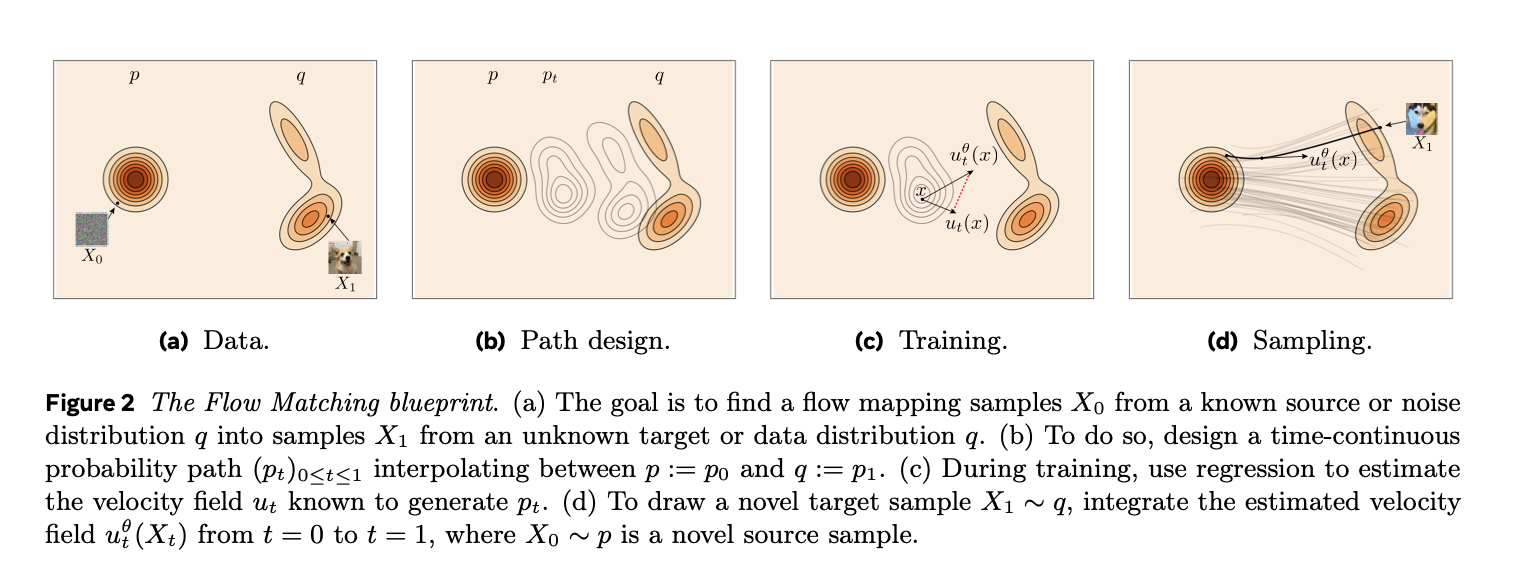
<video width="320" controls autoplay loop muted>
  <source src="https://dsl-lab.github.io/blog/2024/flows/cnf_ex_2.mp4" type="video/mp4">
</video>


In [ ]:
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll

# Data ----------------------------------------------------------
X, _ = make_swiss_roll(5000, noise=0.05)
X = X[:, [0, 2]] / 15.0  # take 2D projection and scale
X = torch.tensor(X, dtype=torch.float32)

# Vector-field model -------------------------------------------
class VelocityField(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2+1, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 2)
        )
    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=-1))

model_fm = VelocityField()
opt = torch.optim.Adam(model_fm.parameters(), lr=1e-3)

# Training ------------------------------------------------------
for step in range(5000):
    x1 = X[torch.randint(0, len(X), (256,))]
    x0 = torch.randn_like(x1)

    t = torch.rand((256, 1))
    x_t = (1 - t) * x0 + t * x1
    v_target = x1 - x0

    pred = model_fm(x_t, t)

    loss = ((pred - v_target) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % 500 == 0:
        print("step", step, "loss", loss.item())

step 0 loss 1.2890948057174683
step 500 loss 0.6317098736763
step 1000 loss 0.6888052225112915
step 1500 loss 0.6083539128303528
step 2000 loss 0.7195599675178528
step 2500 loss 0.6395440101623535
step 3000 loss 0.633483350276947
step 3500 loss 0.6545729637145996
step 4000 loss 0.7137783169746399
step 4500 loss 0.6672579050064087


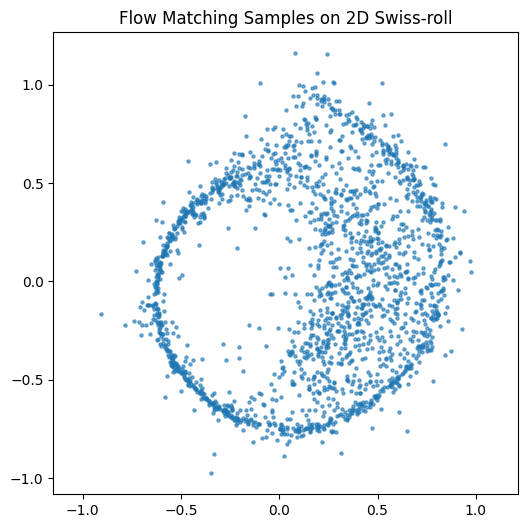

In [ ]:
def fm_sample(n=2000, steps=50):
    x = torch.randn(n, 2)
    dt = 1/steps
    for i in range(steps):
        t = torch.ones(n, 1) * (i / steps)
        x = x + dt * model_fm(x, t).detach()
    return x

samples_fm = fm_sample()

# -------------------- Visualization --------------------
plt.figure(figsize=(6,6))
plt.scatter(samples_fm[:,0], samples_fm[:,1], s=5, alpha=0.6)
plt.title("Flow Matching Samples on 2D Swiss-roll")
plt.axis("equal")
plt.show()

## 🔁 3. Normalizing Flows (NFs)

Normalizing flows learn a bijective transform:

$x = f_\theta(z), \quad z \sim \mathcal{N}(0, I)$

They maximize the exact likelihood:

$\log p(x) = \log p(z) + \log \left| \det \frac{\partial f_\theta}{\partial z} \right|$

Advantages:
- Provide exact likelihood
- Fast sampling (single forward pass)
- Training compute depends on invertible layer

Disadvantage:
- Bijective function needed
- Higher number of parameters required for good performance


<div style="text-align: center;">
  <img src="https://dsl-lab.github.io/blog/2024/flows/norm_flow.png" width="800">
</div>


<video width="320" controls autoplay loop muted>
  <source src="https://dsl-lab.github.io/blog/2024/flows/cnf_ex_1.mp4" type="video/mp4">
</video>







In [ ]:
import torch
import torch.nn as nn

class AffineCoupling(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.s = nn.Sequential(nn.Linear(1, hidden), nn.ReLU(), nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, 1))
        self.t = nn.Sequential(nn.Linear(1, hidden), nn.ReLU(), nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, 1))

    def forward(self, x, mask):
        x1 = x[:, mask.bool()]
        x2 = x[:, (~mask.bool())]
        s = self.s(x1)
        t = self.t(x1)
        y2 = x2 * torch.exp(s) + t

        y = torch.zeros_like(x)
        y[:, mask.bool()] = x1
        y[:, (~mask.bool())] = y2

        logdet = s.sum(dim=1)
        return y, logdet

    def inverse(self, y, mask):
        y1 = y[:, mask.bool()]
        y2 = y[:, (~mask.bool())]
        s = self.s(y1)
        t = self.t(y1)
        x2 = (y2 - t) * torch.exp(-s)

        x = torch.zeros_like(y)
        x[:, mask.bool()] = y1
        x[:, (~mask.bool())] = x2
        return x

class RealNVP(nn.Module):
    def __init__(self, n_layers=3, hidden=128):
        super().__init__()
        self.masks = [torch.tensor([i%2, (i+1)%2], dtype=torch.float32) for i in range(n_layers)]
        self.layers = nn.ModuleList([AffineCoupling(hidden) for _ in range(n_layers)])

    def forward(self, x):
        logdet_total = 0
        for layer, mask in zip(self.layers, self.masks):
            x, logdet = layer(x, mask)
            logdet_total += logdet
        return x, logdet_total

    def inverse(self, z):
        for layer, mask in reversed(list(zip(self.layers, self.masks))):
            z = layer.inverse(z, mask)
        return z

flow = RealNVP(n_layers=6, hidden=256)
opt = torch.optim.Adam(flow.parameters(), lr=1e-3)

# training loop
for step in range(3000):
    x = X[torch.randint(0, len(X), (256,))]
    y, logdet = flow(x)
    prior = -0.5 * (y**2).sum(dim=1)
    loss = -(prior + logdet).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % 500 == 0:
        print("step", step, "loss", loss.item())

step 0 loss 0.055461008101701736
step 500 loss 0.21424362063407898
step 1000 loss -1.5569398403167725
step 1500 loss -2.449744462966919
step 2000 loss -2.6630234718322754
step 2500 loss -2.7081611156463623


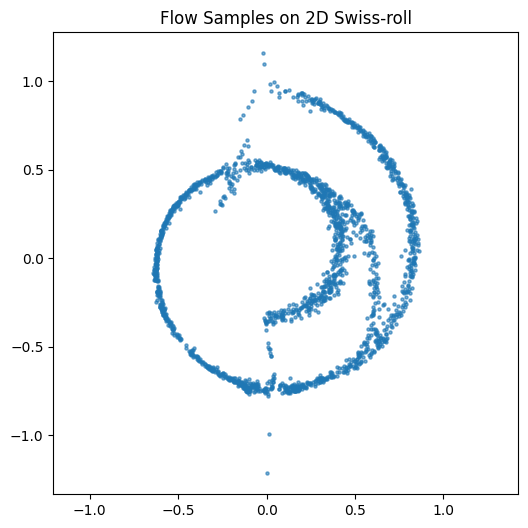

In [ ]:
def sample_flow(n=2000):
    z = torch.randn(n, 2)
    return flow.inverse(z).detach()

samples_flow = sample_flow()
# -------------------- Visualization --------------------
plt.figure(figsize=(6,6))
plt.scatter(samples_flow[:,0], samples_flow[:,1], s=5, alpha=0.6)
plt.title("Flow Samples on 2D Swiss-roll")
plt.axis("equal")
plt.show()

### Visualize all the samples

In [ ]:
import matplotlib.pyplot as plt
import torch

# --- Replace these with your sampler functions ----------------
# samples = ddpm_sample(2000)
# samples = flow_matching_sample(2000)
# samples = normalizing_flow_sample(2000)

def plot_all(ddpm_samples, fm_samples, nf_samples, data=None):

    fig, axes = plt.subplots(1, 4 if data is not None else 3, figsize=(16,4))

    # Optional: plot real data
    if data is not None:
        axes[0].scatter(data[:,0], data[:,1], s=4, alpha=0.5)
        axes[0].set_title("Real Data")
        axes[0].axis("equal")
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        ax1 = axes[1]
    else:
        ax1 = axes[0]

    # --- Diffusion samples ---
    ax1.scatter(ddpm_samples[:,0], ddpm_samples[:,1], s=4, alpha=0.5)
    ax1.set_title("Diffusion Model")
    ax1.axis("equal")
    ax1.set_xticks([])
    ax1.set_yticks([])

    # --- Flow Matching samples ---
    ax2 = axes[1] if data is None else axes[2]
    ax2.scatter(fm_samples[:,0], fm_samples[:,1], s=4, alpha=0.5)
    ax2.set_title("Flow Matching")
    ax2.axis("equal")
    ax2.set_xticks([])
    ax2.set_yticks([])

    # --- Normalizing Flow samples ---
    ax3 = axes[2] if data is None else axes[3]
    ax3.scatter(nf_samples[:,0], nf_samples[:,1], s=4, alpha=0.5)
    ax3.set_title("Normalizing Flow")
    ax3.axis("equal")
    ax3.set_xticks([])
    ax3.set_yticks([])

    plt.tight_layout()
    plt.show()

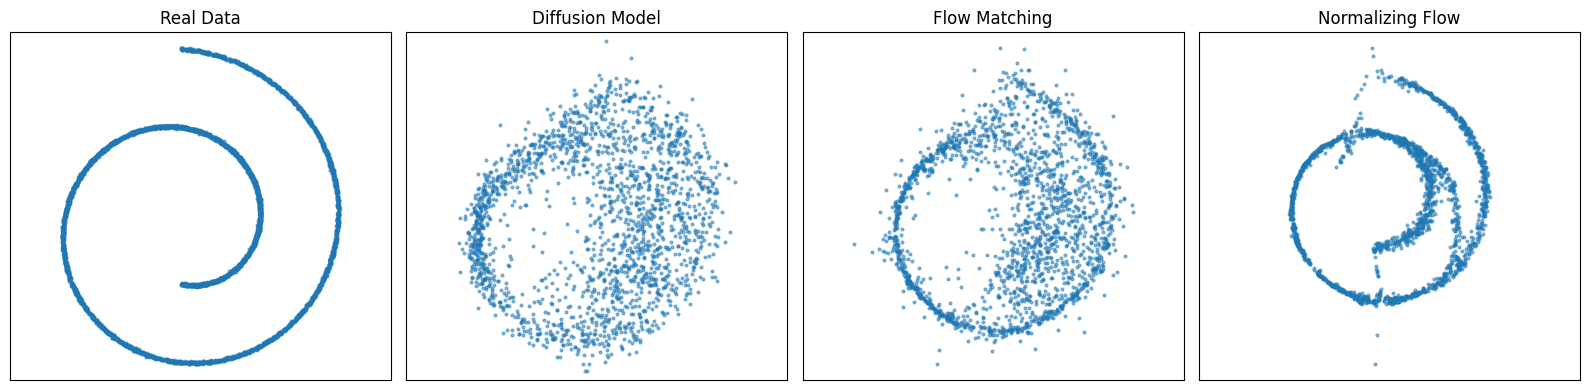

In [ ]:
plot_all(samples_ddpm, samples_fm, samples_flow, X)

> Note that `Flows` usually needs more parameters than `Diffusion Model` due to gradual transform of distribution from a simple distribution.


## ♨ Exercise 4 (10 min):
0. Run through the code of DDPM and Flow Matching.
1. Run the code of normalizing flow with less complex model architecture and training steps:
- change the 3000 steps to 2000 steps in `for step in range(3000)`
- try fewer number of layers by adjusting `n_layers` in `flow = RealNVP(n_layers=6, hidden=256)`

▶ What do you observe? Do you find any issues? If so, what may be the implication?